In [76]:
#Import numpy for arrays
import numpy as np
#Import matplotlib.pyplot for plotting
import matplotlib.pyplot as plt
#Import Landlab raster arrays
from landlab import RasterModelGrid 
#Import landlab graph plotting
from landlab.plot.graph import plot_graph
from landlab import imshow_grid

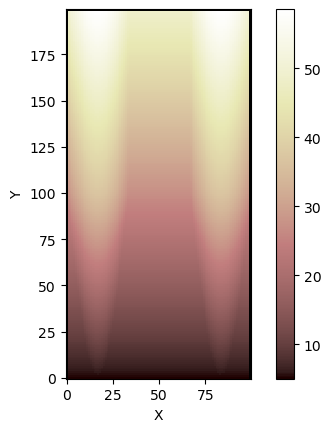

In [104]:
#define the grid
size_x = 100
size_y = 200
spacing = 1.0
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)

# morph the grid with a sine function
ice_height = 10
bedrock_slope = 0.22
soil_thickness = 5
moraine_disappears_at_y = 100

# add the topography    
z_ice = grid.add_zeros('ice_thickness', at='node')
z_soil = grid.add_zeros('soil_thickness', at='node')
z_bed = grid.add_zeros('bedrock_thickness', at='node')
elev = grid.add_zeros('topographic__elevation', at='node')

x = grid.x_of_node
y = grid.y_of_node

# setting ice elevation respected to the base elevation
z = ice_height * np.sin(np.pi*x / (size_x/3)) 
# get z where y is less than moraine_disappears_at_y
z[y<moraine_disappears_at_y] += (y[y<moraine_disappears_at_y] - moraine_disappears_at_y) * ice_height/moraine_disappears_at_y
z[z<0] = 0 # cut the sine function at 0

z_ice += z
z_soil += soil_thickness
z_bed += bedrock_slope * y
def calc_elev(z_ice, z_soil, z_bed):
    elev = z_ice + z_soil + z_bed
    return elev

elev = calc_elev(z_ice,z_soil,z_bed)    

# add boundaries
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_CLOSED
# grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED

grid.imshow(elev)

In [78]:
#create ThawIce class
class ThawIce:
    #define function and input
    def __init__ (self, ice_thickness, soil_thickness, thaw_days_per_year, timestep_years):
        self.ice_thickness = ice_thickness 
        self.soil_thickness = soil_thickness
        self.thaw_days = thaw_days_per_year
        self.dt = timestep_years
    #define thaw function and inputs (dt is number of days
    def calc_thaw_rate(self):
        thaw_rate = []
        for i in range(len(self.soil_thickness)):
            if self.soil_thickness[i] <= 0.05: #m
                thaw_rate.append(self.thaw_days * 0.06) #m/yr
            elif  0.05 < self.soil_thickness[i] < .517:
                thaw_rate.append(0.0857*self.soil_thickness[i]*self.thaw_days)
            elif self.soil_thickness[i] >= .517:
                thaw_rate.append(0)
        self.thaw_rate = np.array(thaw_rate)
    def thaw(self):
         for i in range(len(self.ice_thickness)):
             if self.ice_thickness[i] >= self.thaw_rate[i]*self.dt:
                self.ice_thickness[i] = self.ice_thickness[i] - self.dt*self.thaw_rate[i]
             else:
                self.ice_thickness[i] = 0

In [97]:
oop = ThawIce(ice_thickness = z_ice, soil_thickness = z_soil, thaw_days_per_year = 100, timestep_years = 1)

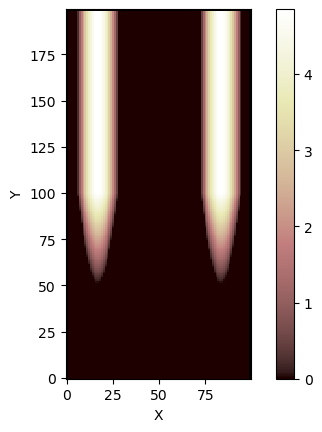

In [101]:
oop.calc_thaw_rate()
oop.thaw()

imshow_grid(grid, oop.ice_thickness)
